# 2015-2023 Test (2024 blind test)

## Logistic Regression

Walk-forward folds:  87%|████████▋ | 72/83 [00:22<00:03,  3.26it/s]



----- Walk-forward Backtest Metrics (2015-2023) -----
accuracy: 0.5448
f1: 0.3773
recall: 0.3445
precision: 0.4170
roc_auc: 0.5221

----- Blind Test on 2024 -----
accuracy: 0.5028
f1: 0.6452
recall: 0.9129
precision: 0.4990
roc_auc: 0.5292


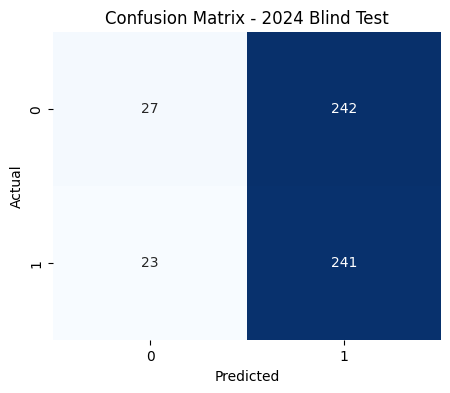


----- Classification Report (2024) -----
              precision    recall  f1-score   support

           0       0.54      0.10      0.17       269
           1       0.50      0.91      0.65       264

    accuracy                           0.50       533
   macro avg       0.52      0.51      0.41       533
weighted avg       0.52      0.50      0.41       533



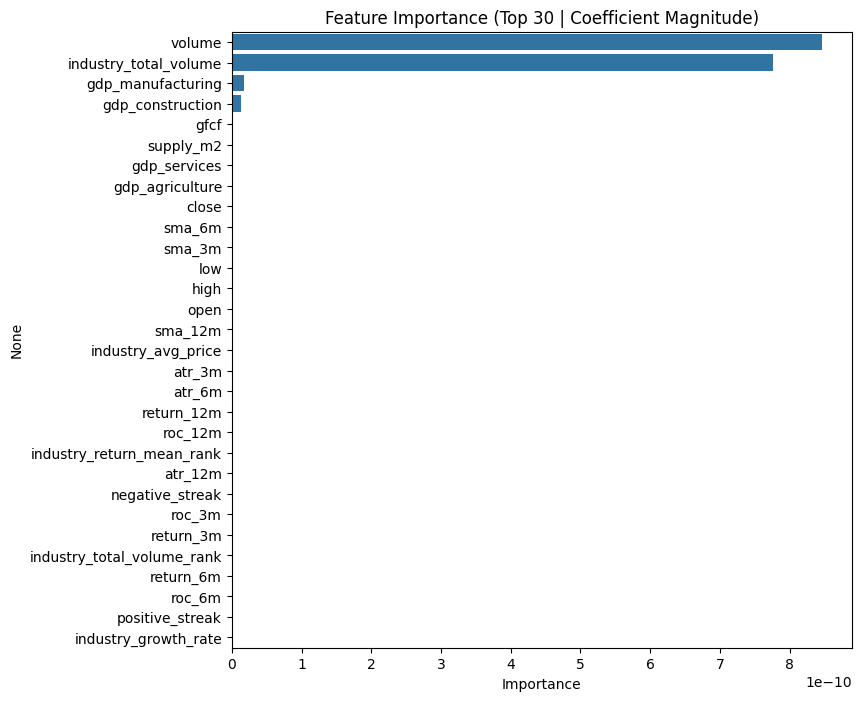

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, accuracy_score, recall_score, precision_score, roc_auc_score,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Config
DATA_PATH = "step5_lagged_data.csv"
TARGET_COL = "direction"
DATE_COL = "month"
TICKER_COL = "ticker"
TRAIN_START = "2015-01"
TRAIN_END = "2023-12"
TEST_YEAR = "2024"
INITIAL_TRAIN_MONTHS = 36  # Used only in walk-forward backtest

LR_PARAMS = {
    "penalty": "l2",
    "solver": "lbfgs",
    "max_iter": 1000,
    "class_weight": "balanced",
    "random_state": 42,
}

# Load and preprocess
df = pd.read_csv(DATA_PATH, parse_dates=[DATE_COL])
df = df.sort_values([TICKER_COL, DATE_COL]).reset_index(drop=True)

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
if TARGET_COL in numeric_cols:
    numeric_cols.remove(TARGET_COL)

X_all = df[numeric_cols]
y_all = df[TARGET_COL].astype(int)
dates = df[DATE_COL].dt.to_period("M")
unique_months = sorted(dates.unique())

# Filter by dates
train_mask = dates.astype(str) <= TRAIN_END
blind_test_mask = dates.astype(str) >= f"{TEST_YEAR}-01"

# Walk-forward backtest (up to 2023)
preds = []
metrics_by_fold = []

for month_idx in tqdm(
    range(INITIAL_TRAIN_MONTHS, len(unique_months)),
    desc="Walk-forward folds"
):
    test_month = unique_months[month_idx]
    if str(test_month) > TRAIN_END:
        break

    train_months = unique_months[:month_idx]
    test_month = unique_months[month_idx]

    train_mask_fold = dates.isin(train_months)
    test_mask_fold = dates == test_month

    X_train, y_train = X_all.loc[train_mask_fold], y_all.loc[train_mask_fold]
    X_test, y_test = X_all.loc[test_mask_fold], y_all.loc[test_mask_fold]

    if X_train.empty or X_test.empty:
        continue

    model = LogisticRegression(**LR_PARAMS)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    for i, idx in enumerate(X_test.index):
        preds.append({
            "index": idx,
            "month": str(test_month),
            "y_true": int(y_test.iloc[i]),
            "y_pred": int(y_pred[i]),
            "y_proba": float(y_proba[i])
        })

    fold_metrics = {
        "month": str(test_month),
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "precision": precision_score(y_test, y_pred, zero_division=0),
    }
    try:
        fold_metrics["roc_auc"] = roc_auc_score(y_test, y_proba)
    except ValueError:
        fold_metrics["roc_auc"] = np.nan

    metrics_by_fold.append(fold_metrics)

# Walk-forward summary
pred_df = pd.DataFrame(preds).set_index("index").sort_index()
print("\n----- Walk-forward Backtest Metrics (2015-2023) -----")
walk_true = pred_df["y_true"]
walk_pred = pred_df["y_pred"]
walk_proba = pred_df["y_proba"]
metrics = {
    "accuracy": accuracy_score(walk_true, walk_pred),
    "f1": f1_score(walk_true, walk_pred, zero_division=0),
    "recall": recall_score(walk_true, walk_pred, zero_division=0),
    "precision": precision_score(walk_true, walk_pred, zero_division=0),
    "roc_auc": roc_auc_score(walk_true, walk_proba),
}
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Train final model on all of 2015-2023
model_final = LogisticRegression(**LR_PARAMS)
model_final.fit(X_all.loc[train_mask], y_all.loc[train_mask])

# Blind test for 2024
X_test_2024 = X_all.loc[blind_test_mask]
y_test_2024 = y_all.loc[blind_test_mask]
y_pred_2024 = model_final.predict(X_test_2024)
y_proba_2024 = model_final.predict_proba(X_test_2024)[:, 1]

# Blind test metrics
print("\n----- Blind Test on 2024 -----")
blind_metrics = {
    "accuracy": accuracy_score(y_test_2024, y_pred_2024),
    "f1": f1_score(y_test_2024, y_pred_2024, zero_division=0),
    "recall": recall_score(y_test_2024, y_pred_2024, zero_division=0),
    "precision": precision_score(y_test_2024, y_pred_2024, zero_division=0),
    "roc_auc": roc_auc_score(y_test_2024, y_proba_2024),
}
for k, v in blind_metrics.items():
    print(f"{k}: {v:.4f}")

# Confusion Matrix for 2024
cm = confusion_matrix(y_test_2024, y_pred_2024)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - 2024 Blind Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\n----- Classification Report (2024) -----")
print(classification_report(y_test_2024, y_pred_2024, zero_division=0))

# Feature Importance (Absolute coefficients)
feat_imp = pd.Series(
    np.abs(model_final.coef_[0]),
    index=numeric_cols
).sort_values(ascending=False)

plt.figure(figsize=(8, 8))
sns.barplot(x=feat_imp.values[:30], y=feat_imp.index[:30])
plt.title("Feature Importance (Top 30 | Coefficient Magnitude)")
plt.xlabel("Importance")
plt.show()

## XG-Boost

## 1. Baseline XG - Untuned

Walk-forward folds:  87%|████████▋ | 72/83 [03:26<00:31,  2.87s/it]



----- Walk-forward Backtest Metrics (2015-2023) -----
accuracy: 0.5758
f1: 0.3185
recall: 0.2476
precision: 0.4462
roc_auc: 0.5475

----- Blind Test on 2024 -----
accuracy: 0.5816
f1: 0.4467
recall: 0.3409
precision: 0.6475
roc_auc: 0.6594


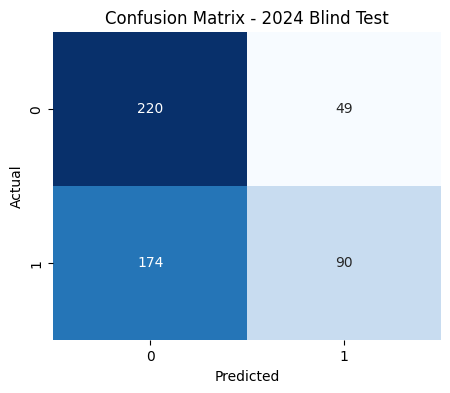


----- Classification Report (2024) -----
              precision    recall  f1-score   support

           0       0.56      0.82      0.66       269
           1       0.65      0.34      0.45       264

    accuracy                           0.58       533
   macro avg       0.60      0.58      0.56       533
weighted avg       0.60      0.58      0.56       533



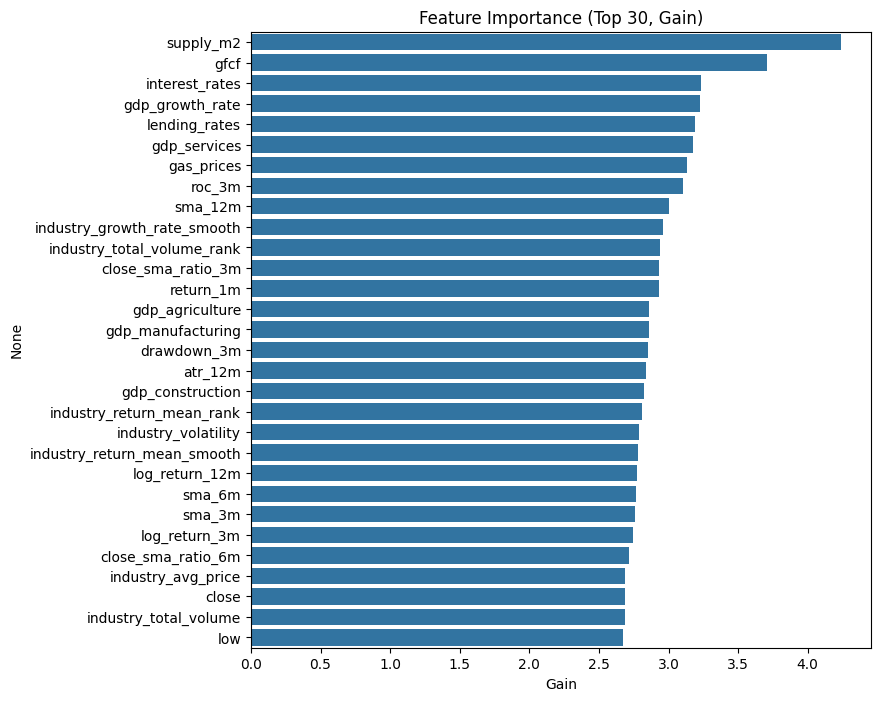

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import (
    f1_score, accuracy_score, recall_score, precision_score,
    roc_auc_score, confusion_matrix, classification_report
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Config
DATA_PATH = "step5_lagged_data.csv"
TARGET_COL = "direction"
DATE_COL = "month"
TICKER_COL = "ticker"
TRAIN_START = "2015-01"
TRAIN_END = "2023-12"
TEST_YEAR = "2024"
INITIAL_TRAIN_MONTHS = 36

XGB_PARAMS = {
    "n_estimators": 500,
    "max_depth": 6,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "use_label_encoder": False,
    "eval_metric": "logloss",
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "random_state": 42,
}

# Load and preprocess
df = pd.read_csv(DATA_PATH, parse_dates=[DATE_COL])
df = df.sort_values([TICKER_COL, DATE_COL]).reset_index(drop=True)

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
if TARGET_COL in numeric_cols:
    numeric_cols.remove(TARGET_COL)

X_all = df[numeric_cols]
y_all = df[TARGET_COL].astype(int)
dates = df[DATE_COL].dt.to_period("M")
unique_months = sorted(dates.unique())

# Filter by dates
train_mask = dates.astype(str) <= TRAIN_END
blind_test_mask = dates.astype(str) >= f"{TEST_YEAR}-01"

# Walk-forward backtest (up to 2023)
preds = []
metrics_by_fold = []

for month_idx in tqdm(
    range(INITIAL_TRAIN_MONTHS, len(unique_months)),
    desc="Walk-forward folds"
):
    test_month = unique_months[month_idx]
    if str(test_month) > TRAIN_END:
        break

    train_months = unique_months[:month_idx]
    test_month = unique_months[month_idx]

    train_mask_fold = dates.isin(train_months)
    test_mask_fold = dates == test_month

    X_train, y_train = X_all.loc[train_mask_fold], y_all.loc[train_mask_fold]
    X_test, y_test = X_all.loc[test_mask_fold], y_all.loc[test_mask_fold]

    if X_train.empty or X_test.empty:
        continue

    model = XGBClassifier(**XGB_PARAMS)
    model.fit(X_train, y_train, verbose=False)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    for i, idx in enumerate(X_test.index):
        preds.append({
            "index": idx,
            "month": str(test_month),
            "y_true": int(y_test.iloc[i]),
            "y_pred": int(y_pred[i]),
            "y_proba": float(y_proba[i])
        })

    fold_metrics = {
        "month": str(test_month),
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "precision": precision_score(y_test, y_pred, zero_division=0),
    }
    try:
        fold_metrics["roc_auc"] = roc_auc_score(y_test, y_proba)
    except ValueError:
        fold_metrics["roc_auc"] = np.nan

    metrics_by_fold.append(fold_metrics)

# Walk-forward summary
pred_df = pd.DataFrame(preds).set_index("index").sort_index()
print("\n----- Walk-forward Backtest Metrics (2015-2023) -----")
walk_true = pred_df["y_true"]
walk_pred = pred_df["y_pred"]
walk_proba = pred_df["y_proba"]
metrics = {
    "accuracy": accuracy_score(walk_true, walk_pred),
    "f1": f1_score(walk_true, walk_pred, zero_division=0),
    "recall": recall_score(walk_true, walk_pred, zero_division=0),
    "precision": precision_score(walk_true, walk_pred, zero_division=0),
    "roc_auc": roc_auc_score(walk_true, walk_proba),
}
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Train final model on all of 2015-2023
model_final = XGBClassifier(**XGB_PARAMS)
model_final.fit(X_all.loc[train_mask], y_all.loc[train_mask], verbose=False)

# Blind test for 2024
X_test_2024 = X_all.loc[blind_test_mask]
y_test_2024 = y_all.loc[blind_test_mask]
y_pred_2024 = model_final.predict(X_test_2024)
y_proba_2024 = model_final.predict_proba(X_test_2024)[:, 1]

# Blind test metrics
print("\n----- Blind Test on 2024 -----")
blind_metrics = {
    "accuracy": accuracy_score(y_test_2024, y_pred_2024),
    "f1": f1_score(y_test_2024, y_pred_2024, zero_division=0),
    "recall": recall_score(y_test_2024, y_pred_2024, zero_division=0),
    "precision": precision_score(y_test_2024, y_pred_2024, zero_division=0),
    "roc_auc": roc_auc_score(y_test_2024, y_proba_2024),
}
for k, v in blind_metrics.items():
    print(f"{k}: {v:.4f}")

# Confusion Matrix for 2024
cm = confusion_matrix(y_test_2024, y_pred_2024)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - 2024 Blind Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\n----- Classification Report (2024) -----")
print(classification_report(y_test_2024, y_pred_2024, zero_division=0))

# Feature Importance (Gain)
feat_imp = model_final.get_booster().get_score(importance_type="gain")
feat_imp = pd.Series(feat_imp).sort_values(ascending=False)

plt.figure(figsize=(8, 8))
sns.barplot(x=feat_imp.values[:30], y=feat_imp.index[:30])
plt.title("Feature Importance (Top 30, Gain)")
plt.xlabel("Gain")
plt.show()

## XGBoost Tuned to Improve Precision

In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_score
from sklearn.model_selection import ParameterGrid
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings("ignore")

# Config
DATA_PATH = "step5_lagged_data.csv"
TARGET_COL = "direction"
DATE_COL = "month"
TICKER_COL = "ticker"
TRAIN_START = "2015-01"
TRAIN_END = "2023-12"
VAL_YEAR = "2023"

# Load and preprocess
df = pd.read_csv(DATA_PATH, parse_dates=[DATE_COL])
df = df.sort_values([TICKER_COL, DATE_COL]).reset_index(drop=True)

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
if TARGET_COL in numeric_cols:
    numeric_cols.remove(TARGET_COL)

X_all = df[numeric_cols]
y_all = df[TARGET_COL].astype(int)
dates = df[DATE_COL].dt.to_period("M")

# Prepare time-based train and validation splits for tuning
val_mask = dates.astype(str).str.startswith(VAL_YEAR)
train_mask_tune = (dates.astype(str) >= TRAIN_START) & (dates.astype(str) < f"{VAL_YEAR}-01")

X_train, y_train = X_all.loc[train_mask_tune], y_all.loc[train_mask_tune]
X_val, y_val = X_all.loc[val_mask], y_all.loc[val_mask]

# Initialize base XGBoost classifier with GPU support
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    use_label_encoder=False,
    random_state=42,
)

# Define parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.2, 0.4],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 2],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 400],
}

# Convert parameter grid to list of combinations
param_list = list(ParameterGrid(param_grid))
results = []

print(f"Total combinations to test: {len(param_list)}")

# Loop through each combination
best_precision = -1
xgb_tuned_model = None
best_params = None

for params in tqdm(param_list, desc="Grid Search Progress"):
    xgb = xgb_base.set_params(**params)
    xgb.fit(X_train, y_train)
    
    y_pred = xgb.predict(X_val)
    precision = precision_score(y_val, y_pred, zero_division=0)
    
    if precision > best_precision:
        best_precision = precision
        xgb_tuned_model = xgb
        best_params = params.copy()

print("\nBest model found:")
print(best_params)
print(f"Best validation precision: {best_precision:.4f}")

# Save the tuned model to disk
with open("xgb_tuned_model.pkl", "wb") as f:
    pickle.dump(xgb_tuned_model, f)

print("\nTuned model saved as 'xgb_tuned_model.pkl'")

Total combinations to test: 5832


Grid Search Progress: 100%|██████████| 5832/5832 [1:34:52<00:00,  1.02it/s]  


Best model found:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.6}
Best validation precision: 0.5119

Tuned model saved as 'xgb_tuned_model.pkl'


Model above in action

Walk-forward folds:  87%|████████▋ | 72/83 [01:21<00:12,  1.13s/it]



----- Walk-forward Backtest Metrics (2015-2023, Tuned XGBoost) -----
accuracy: 0.5773
f1: 0.3383
recall: 0.2699
precision: 0.4531
roc_auc: 0.5451

----- Blind Test on 2024 (Tuned XGBoost) -----
accuracy: 0.6191
f1: 0.5061
recall: 0.3939
precision: 0.7075
roc_auc: 0.6644


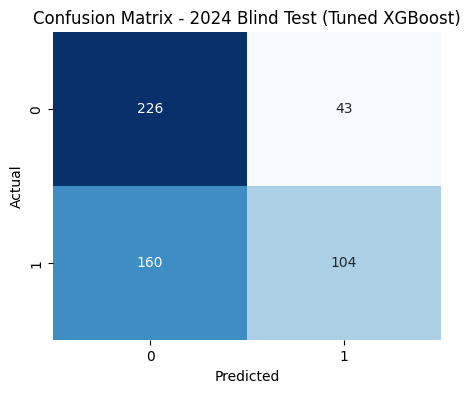


----- Classification Report (2024, Tuned XGBoost) -----
              precision    recall  f1-score   support

           0       0.59      0.84      0.69       269
           1       0.71      0.39      0.51       264

    accuracy                           0.62       533
   macro avg       0.65      0.62      0.60       533
weighted avg       0.65      0.62      0.60       533



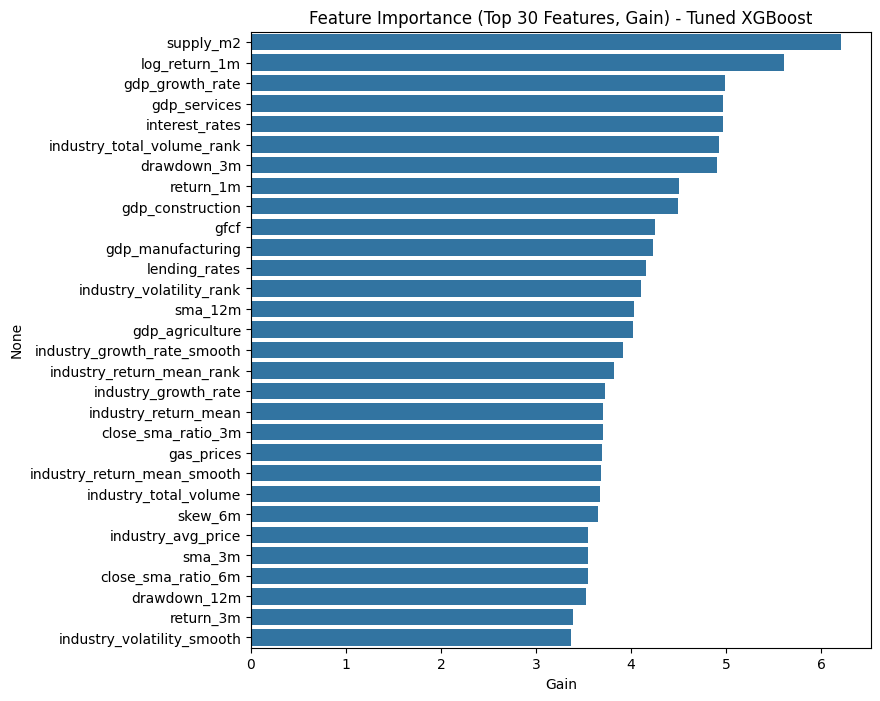

In [8]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    roc_auc_score, confusion_matrix, classification_report
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

# Config
DATA_PATH = "step5_lagged_data.csv"
TARGET_COL = "direction"
DATE_COL = "month"
TICKER_COL = "ticker"
TRAIN_END = "2023-12"
TEST_YEAR = "2024"
INITIAL_TRAIN_MONTHS = 36

# Load and preprocess data
df = pd.read_csv(DATA_PATH, parse_dates=[DATE_COL])
df = df.sort_values([TICKER_COL, DATE_COL]).reset_index(drop=True)

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
if TARGET_COL in numeric_cols:
    numeric_cols.remove(TARGET_COL)

X_all = df[numeric_cols]
y_all = df[TARGET_COL].astype(int)
dates = df[DATE_COL].dt.to_period("M")
unique_months = sorted(dates.unique())

# Walk-forward backtest (2015-2023)
preds = []
metrics_by_fold = []

# Load tuned model
with open("xgb_tuned_model.pkl", "rb") as f:
    xgb_tuned_model = pickle.load(f)

for month_idx in tqdm(
    range(INITIAL_TRAIN_MONTHS, len(unique_months)),
    desc="Walk-forward folds"
):
    test_month = unique_months[month_idx]
    if str(test_month) > TRAIN_END:
        break  # Stop at end of 2023

    train_months = unique_months[:month_idx]
    test_mask = dates == test_month
    train_mask = dates.isin(train_months)

    X_train, y_train = X_all.loc[train_mask], y_all.loc[train_mask]
    X_test, y_test = X_all.loc[test_mask], y_all.loc[test_mask]

    if X_train.empty or X_test.empty:
        continue

    # Train tuned model on walk-forward split
    model = xgb_tuned_model.set_params(verbosity=0)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Collect predictions
    for i, idx in enumerate(X_test.index):
        preds.append({
            "index": idx,
            "month": str(test_month),
            "y_true": int(y_test.iloc[i]),
            "y_pred": int(y_pred[i]),
            "y_proba": float(y_proba[i])
        })

    # Fold-level metrics
    fold_metrics = {
        "month": str(test_month),
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "precision": precision_score(y_test, y_pred, zero_division=0),
    }
    try:
        fold_metrics["roc_auc"] = roc_auc_score(y_test, y_proba)
    except ValueError:
        fold_metrics["roc_auc"] = np.nan

    metrics_by_fold.append(fold_metrics)

# Walk-forward summary metrics
pred_df = pd.DataFrame(preds).set_index("index").sort_index()
walk_true = pred_df["y_true"]
walk_pred = pred_df["y_pred"]
walk_proba = pred_df["y_proba"]

print("\n----- Walk-forward Backtest Metrics (2015-2023, Tuned XGBoost) -----")
walk_metrics = {
    "accuracy": accuracy_score(walk_true, walk_pred),
    "f1": f1_score(walk_true, walk_pred, zero_division=0),
    "recall": recall_score(walk_true, walk_pred, zero_division=0),
    "precision": precision_score(walk_true, walk_pred, zero_division=0),
    "roc_auc": roc_auc_score(walk_true, walk_proba),
}
for k, v in walk_metrics.items():
    print(f"{k}: {v:.4f}")

# Train final model on all 2015-2023 data
train_mask_full = dates.astype(str) <= TRAIN_END
X_train_full = X_all.loc[train_mask_full]
y_train_full = y_all.loc[train_mask_full]

xgb_tuned_model.fit(X_train_full, y_train_full)

# Blind test for 2024
test_mask_2024 = dates.astype(str).str.startswith(TEST_YEAR)
X_test_2024 = X_all.loc[test_mask_2024]
y_test_2024 = y_all.loc[test_mask_2024]
y_pred_2024 = xgb_tuned_model.predict(X_test_2024)
y_proba_2024 = xgb_tuned_model.predict_proba(X_test_2024)[:, 1]

print("\n----- Blind Test on 2024 (Tuned XGBoost) -----")
blind_metrics = {
    "accuracy": accuracy_score(y_test_2024, y_pred_2024),
    "f1": f1_score(y_test_2024, y_pred_2024, zero_division=0),
    "recall": recall_score(y_test_2024, y_pred_2024, zero_division=0),
    "precision": precision_score(y_test_2024, y_pred_2024, zero_division=0),
    "roc_auc": roc_auc_score(y_test_2024, y_proba_2024),
}
for k, v in blind_metrics.items():
    print(f"{k}: {v:.4f}")

# Confusion Matrix for 2024
cm = confusion_matrix(y_test_2024, y_pred_2024)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - 2024 Blind Test (Tuned XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\n----- Classification Report (2024, Tuned XGBoost) -----")
print(classification_report(y_test_2024, y_pred_2024, zero_division=0))

# Feature Importance (Gain)
feat_imp = xgb_tuned_model.get_booster().get_score(importance_type="gain")
feat_imp = pd.Series(feat_imp).sort_values(ascending=False)

plt.figure(figsize=(8, 8))
sns.barplot(x=feat_imp.values[:30], y=feat_imp.index[:30])
plt.title("Feature Importance (Top 30 Features, Gain) - Tuned XGBoost")
plt.xlabel("Gain")
plt.show()

## Metric Performance Over Time

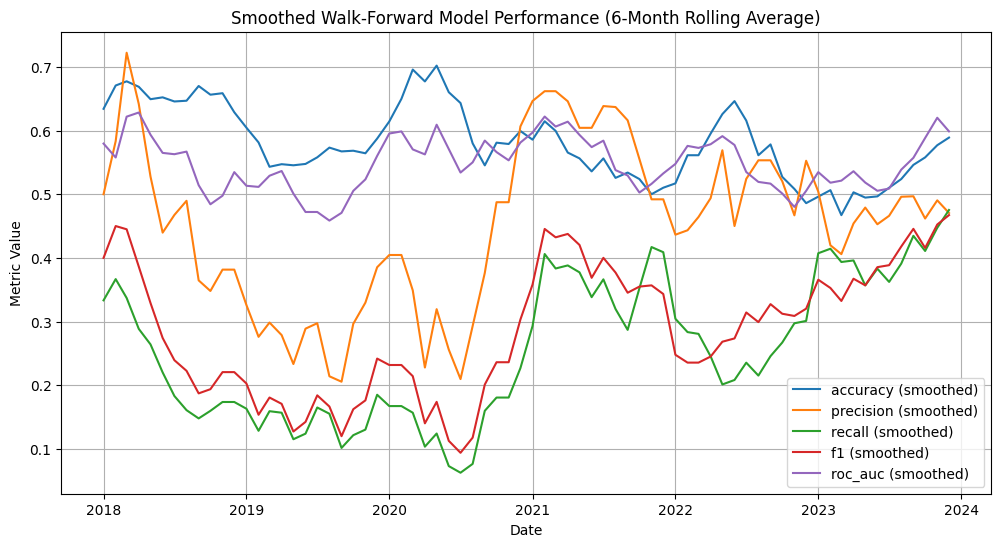

In [12]:
# Smooth performance metrics with rolling mean
# Convert walk-forward metrics to DataFrame
metrics_df = pd.DataFrame(metrics_by_fold)
metrics_df["month"] = pd.to_datetime(metrics_df["month"])
metrics_df.set_index("month", inplace=True)

rolling_window = 6  # e.g., 6-month rolling average
metrics_smooth = metrics_df.rolling(window=rolling_window, min_periods=1).mean()

# Plot smoothed performance
plt.figure(figsize=(12, 6))
for metric in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    plt.plot(metrics_smooth.index, metrics_smooth[metric], label=f"{metric} (smoothed)")

plt.title(f"Smoothed Walk-Forward Model Performance ({rolling_window}-Month Rolling Average)")
plt.xlabel("Date")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)
plt.show()

# 2. Random Forest

## Baseline Forest

Walk-forward folds:  87%|████████▋ | 72/83 [01:11<00:10,  1.00it/s]



----- Walk-forward Backtest Metrics (2015-2023) -----
accuracy: 0.5881
f1: 0.3175
recall: 0.2394
precision: 0.4714
roc_auc: 0.5549

----- Blind Test on 2024 -----
accuracy: 0.5947
f1: 0.4545
recall: 0.3409
precision: 0.6818
roc_auc: 0.6627


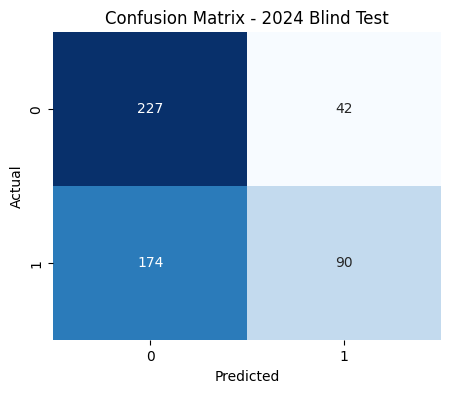


----- Classification Report (2024) -----
              precision    recall  f1-score   support

           0       0.57      0.84      0.68       269
           1       0.68      0.34      0.45       264

    accuracy                           0.59       533
   macro avg       0.62      0.59      0.57       533
weighted avg       0.62      0.59      0.57       533



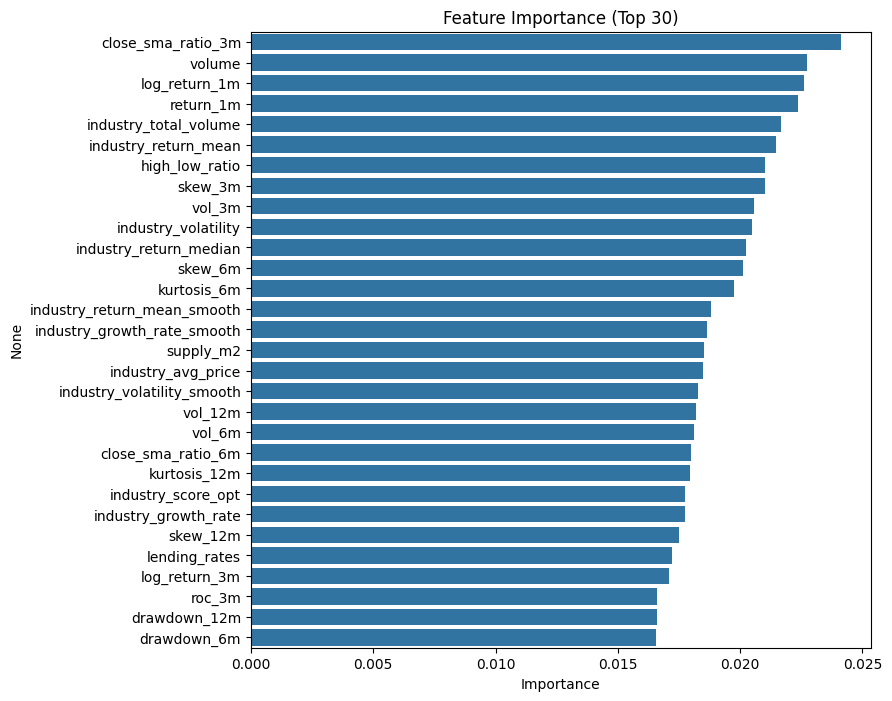

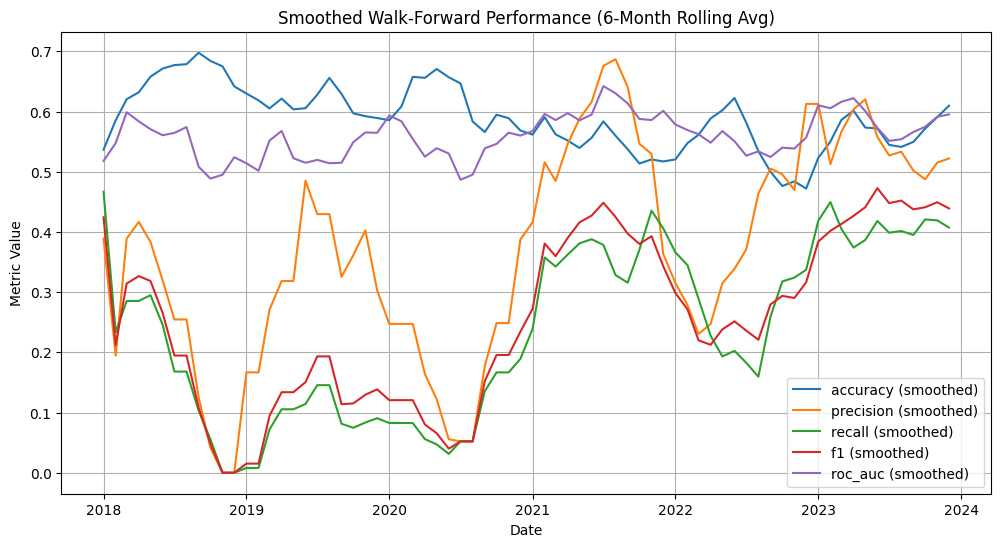

In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score, accuracy_score, recall_score, precision_score,
    roc_auc_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# Config
DATA_PATH = "step5_lagged_data.csv"
TARGET_COL = "direction"
DATE_COL = "month"
TICKER_COL = "ticker"
TRAIN_START = "2015-01"
TRAIN_END = "2023-12"
TEST_YEAR = "2024"
INITIAL_TRAIN_MONTHS = 36  # at least 3 years of data before first test

RF_PARAMS = {
    "n_estimators": 300,
    "max_depth": None,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "class_weight": "balanced",  # handle class imbalance
    "random_state": 42,
    "n_jobs": -1,
}

# Load and preprocess
df = pd.read_csv(DATA_PATH, parse_dates=[DATE_COL])
df = df.sort_values([TICKER_COL, DATE_COL]).reset_index(drop=True)

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
if TARGET_COL in numeric_cols:
    numeric_cols.remove(TARGET_COL)

X_all = df[numeric_cols]
y_all = df[TARGET_COL].astype(int)
dates = df[DATE_COL].dt.to_period("M")
unique_months = sorted(dates.unique())

train_mask = dates.astype(str) <= TRAIN_END
blind_test_mask = dates.astype(str) >= f"{TEST_YEAR}-01"

# Walk-forward backtest (up to 2023)
preds = []
metrics_by_fold = []

for month_idx in tqdm(
    range(INITIAL_TRAIN_MONTHS, len(unique_months)),
    desc="Walk-forward folds"
):
    test_month = unique_months[month_idx]
    if str(test_month) > TRAIN_END:
        break

    train_months = unique_months[:month_idx]
    test_month = unique_months[month_idx]

    train_mask_fold = dates.isin(train_months)
    test_mask_fold = dates == test_month

    X_train, y_train = X_all.loc[train_mask_fold], y_all.loc[train_mask_fold]
    X_test, y_test = X_all.loc[test_mask_fold], y_all.loc[test_mask_fold]

    if X_train.empty or X_test.empty:
        continue

    model = RandomForestClassifier(**RF_PARAMS)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    for i, idx in enumerate(X_test.index):
        preds.append({
            "index": idx,
            "month": str(test_month),
            "y_true": int(y_test.iloc[i]),
            "y_pred": int(y_pred[i]),
            "y_proba": float(y_proba[i])
        })

    fold_metrics = {
        "month": str(test_month),
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "precision": precision_score(y_test, y_pred, zero_division=0),
    }
    try:
        fold_metrics["roc_auc"] = roc_auc_score(y_test, y_proba)
    except ValueError:
        fold_metrics["roc_auc"] = np.nan

    metrics_by_fold.append(fold_metrics)

# Walk-forward summary
pred_df = pd.DataFrame(preds).set_index("index").sort_index()
print("\n----- Walk-forward Backtest Metrics (2015-2023) -----")
walk_true = pred_df["y_true"]
walk_pred = pred_df["y_pred"]
walk_proba = pred_df["y_proba"]
metrics = {
    "accuracy": accuracy_score(walk_true, walk_pred),
    "f1": f1_score(walk_true, walk_pred, zero_division=0),
    "recall": recall_score(walk_true, walk_pred, zero_division=0),
    "precision": precision_score(walk_true, walk_pred, zero_division=0),
    "roc_auc": roc_auc_score(walk_true, walk_proba),
}
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Train final model on all data up to 2023
model_final = RandomForestClassifier(**RF_PARAMS)
model_final.fit(X_all.loc[train_mask], y_all.loc[train_mask])

# Blind test for 2024
X_test_2024 = X_all.loc[blind_test_mask]
y_test_2024 = y_all.loc[blind_test_mask]
y_pred_2024 = model_final.predict(X_test_2024)
y_proba_2024 = model_final.predict_proba(X_test_2024)[:, 1]

print("\n----- Blind Test on 2024 -----")
blind_metrics = {
    "accuracy": accuracy_score(y_test_2024, y_pred_2024),
    "f1": f1_score(y_test_2024, y_pred_2024, zero_division=0),
    "recall": recall_score(y_test_2024, y_pred_2024, zero_division=0),
    "precision": precision_score(y_test_2024, y_pred_2024, zero_division=0),
    "roc_auc": roc_auc_score(y_test_2024, y_proba_2024),
}
for k, v in blind_metrics.items():
    print(f"{k}: {v:.4f}")

# Confusion matrix for 2024
cm = confusion_matrix(y_test_2024, y_pred_2024)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - 2024 Blind Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\n----- Classification Report (2024) -----")
print(classification_report(y_test_2024, y_pred_2024, zero_division=0))

# Feature Importance
feat_imp = pd.Series(model_final.feature_importances_, index=numeric_cols).sort_values(ascending=False)
plt.figure(figsize=(8, 8))
sns.barplot(x=feat_imp.values[:30], y=feat_imp.index[:30])
plt.title("Feature Importance (Top 30)")
plt.xlabel("Importance")
plt.show()

# Plot walk-forward performance (smoothed)
metrics_df = pd.DataFrame(metrics_by_fold)
metrics_df["month"] = pd.to_datetime(metrics_df["month"])
metrics_df.set_index("month", inplace=True)

rolling_window = 6
metrics_smooth = metrics_df.rolling(window=rolling_window, min_periods=1).mean()

plt.figure(figsize=(12, 6))
for metric in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    plt.plot(metrics_smooth.index, metrics_smooth[metric], label=f"{metric} (smoothed)")
plt.title(f"Smoothed Walk-Forward Performance ({rolling_window}-Month Rolling Avg)")
plt.xlabel("Date")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

# -----------------------------
# Load model
# -----------------------------
MODEL_PKL = "ensemble_model.pkl"  # adjust to your actual model file
with open(MODEL_PKL, "rb") as f:
    model = pickle.load(f)

# -----------------------------
# Load your dataset
# -----------------------------
df = pd.read_csv("step5_lagged_data.csv", parse_dates=["month"])  # must contain 'month' and target column
target_col = "d"  # change to your target column name
X = df.drop(columns=[target_col])
y = df[target_col]

# -----------------------------
# Split by year
# -----------------------------
df_2024 = df[df["month"].dt.year == 2024]
df_2025 = df[df["month"].dt.year == 2025]

X_2024 = df_2024.drop(columns=[target_col])
y_2024 = df_2024[target_col]

X_2025 = df_2025.drop(columns=[target_col])
y_2025 = df_2025[target_col]

# -----------------------------
# Predict and evaluate per year
# -----------------------------
for year, X_test, y_test in [(2024, X_2024, y_2024), (2025, X_2025, y_2025)]:
    if len(X_test) == 0:
        print(f"No samples found for {year}")
        continue

    y_pred = model.predict(X_test)

    print(f"\n=== {year} Classification Report ===")
    print(classification_report(y_test, y_pred, digits=3))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix ({year})")
    plt.show()


## Tuned Random Forest for Aggression (Recall)

Total combinations to test: 96



n_estimators:   0%|          | 0/2 [00:00<?, ?it/s]

































































































































































































































































































































































































Tested combo 1/96, Recall: 0.1651


Tested combo 2/96, Recall: 0.1192


Tested combo 3/96, Recall: 0.1599


Tested combo 4/96, Recall: 0.1105


Tested combo 5/96, Recall: 0.1569


Tested combo 6/96, Recall: 0.1585


Tested combo 7/96, Recall: 0.1582


Tested combo 8/96, Recall: 0.1531


Tested combo 9/96, Recall: 0.1762


Tested combo 10/96, Recall: 0.1517


Tested combo 11/96, Recall: 0.1691


Tested combo 12/96, Recall: 0.1386


Tested combo 13/96, Recall: 0.1695


Tested combo 14/96, Recall: 0.1753


Tested combo 15/96, Recall: 0.1624


Tested combo 16/96, Recall: 0.1680


Tested combo 17/96, Recall: 0.1035


Tested combo 18/96, Recall: 0.2777


Tested combo 19/96, Recall: 0.0991


Tested combo 20/96, Recall: 0.2745


Tested combo 21/96, Recall: 0.1134


Tested combo 22/96, Recall: 0.2885


Tested combo 23/96, Recall: 0.1092


Tested combo 24/96, Recall: 0.2812


Tested combo 25/96, Recall: 0.1121


Tested combo 26/96, Recall: 0.2859


Tested combo 27/96, Recall: 0.1018


Tested combo 28/96, Recall: 0.2875


Tested combo 29/96, Recall: 0.1108


Tested combo 30/96, Recall: 0.2902


Tested combo 31/96, Recall: 0.0947


Tested combo 32/96, Recall: 0.2913


Tested combo 33/96, Recall: 0.1380


Tested combo 34/96, Recall: 0.1751


Tested combo 35/96, Recall: 0.1413


Tested combo 36/96, Recall: 0.1730


Tested combo 37/96, Recall: 0.1449


Tested combo 38/96, Recall: 0.2008


Tested combo 39/96, Recall: 0.1357


Tested combo 40/96, Recall: 0.2255


Tested combo 41/96, Recall: 0.1431


Tested combo 42/96, Recall: 0.1984


Tested combo 43/96, Recall: 0.1341


Tested combo 44/96, Recall: 0.1984


Tested combo 45/96, Recall: 0.1422


Tested combo 46/96, Recall: 0.2186


Tested combo 47/96, Recall: 0.1343








































































































































































































































































































































































































n_estimators:  50%|█████     | 1/2 [56:44<56:44, 3404.15s/it]

Tested combo 48/96, Recall: 0.2246


Tested combo 49/96, Recall: 0.1674


Tested combo 50/96, Recall: 0.1146


Tested combo 51/96, Recall: 0.1568


Tested combo 52/96, Recall: 0.1140


Tested combo 53/96, Recall: 0.1652


Tested combo 54/96, Recall: 0.1597


Tested combo 55/96, Recall: 0.1569


Tested combo 56/96, Recall: 0.1491


Tested combo 57/96, Recall: 0.1803


Tested combo 58/96, Recall: 0.1435


Tested combo 59/96, Recall: 0.1606


Tested combo 60/96, Recall: 0.1385


Tested combo 61/96, Recall: 0.1718


Tested combo 62/96, Recall: 0.1705


Tested combo 63/96, Recall: 0.1560


Tested combo 64/96, Recall: 0.1686


Tested combo 65/96, Recall: 0.1059


Tested combo 66/96, Recall: 0.2738


Tested combo 67/96, Recall: 0.0966


Tested combo 68/96, Recall: 0.2777


Tested combo 69/96, Recall: 0.1135


Tested combo 70/96, Recall: 0.2876


Tested combo 71/96, Recall: 0.1080


Tested combo 72/96, Recall: 0.2913


Tested combo 73/96, Recall: 0.1127


Tested combo 74/96, Recall: 0.2788


Tested combo 75/96, Recall: 0.1006


Tested combo 76/96, Recall: 0.2907


Tested combo 77/96, Recall: 0.1102


Tested combo 78/96, Recall: 0.2931


Tested combo 79/96, Recall: 0.0959


Tested combo 80/96, Recall: 0.2889


Tested combo 81/96, Recall: 0.1401


Tested combo 82/96, Recall: 0.1800


Tested combo 83/96, Recall: 0.1401


Tested combo 84/96, Recall: 0.1763


Tested combo 85/96, Recall: 0.1435


Tested combo 86/96, Recall: 0.2053


Tested combo 87/96, Recall: 0.1347


Tested combo 88/96, Recall: 0.2146


Tested combo 89/96, Recall: 0.1454


Tested combo 90/96, Recall: 0.1960


Tested combo 91/96, Recall: 0.1348


Tested combo 92/96, Recall: 0.1959


Tested combo 93/96, Recall: 0.1491


Tested combo 94/96, Recall: 0.2144


Tested combo 95/96, Recall: 0.1339








































































































































































































































































































































































































n_estimators: 100%|██████████| 2/2 [2:07:14<00:00, 3817.40s/it]


Tested combo 96/96, Recall: 0.2162

Best model found:
{'n_estimators': 500, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1}
Best validation recall: 0.2931

Saved as 'rf_aggressive_model.pkl'

----- Blind Test on 2024 -----
accuracy: 0.5947
f1: 0.5462
recall: 0.4924
precision: 0.6132
roc_auc: 0.6562


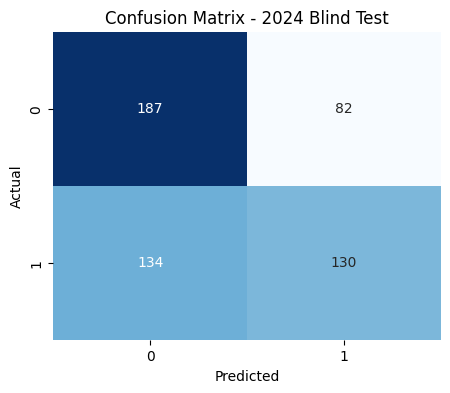


----- Classification Report (2024) -----
              precision    recall  f1-score   support

           0       0.58      0.70      0.63       269
           1       0.61      0.49      0.55       264

    accuracy                           0.59       533
   macro avg       0.60      0.59      0.59       533
weighted avg       0.60      0.59      0.59       533



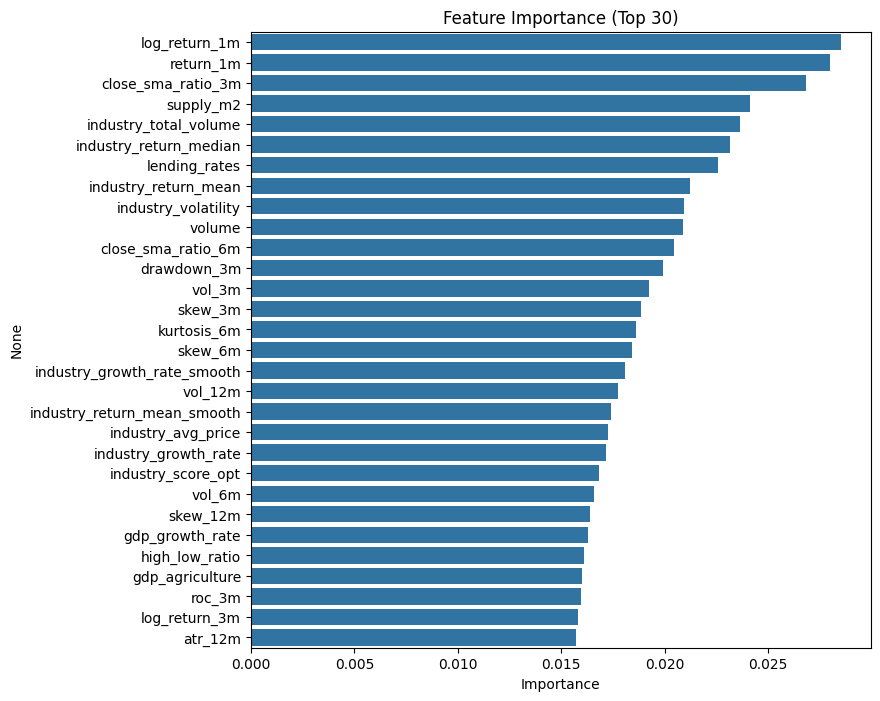

In [16]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score, accuracy_score, recall_score, precision_score,
    roc_auc_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

# Config
DATA_PATH = "step5_lagged_data.csv"
TARGET_COL = "direction"
DATE_COL = "month"
TICKER_COL = "ticker"
TRAIN_START = "2015-01"
TRAIN_END = "2023-12"
TEST_YEAR = "2024"
INITIAL_TRAIN_MONTHS = 36  # at least 3 years of data before first test

# Parameter grid for more aggressive behavior
param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [None, 8, 12],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ['sqrt', 'log2'],
    "class_weight": [None, "balanced"],
}

# Load and preprocess
df = pd.read_csv(DATA_PATH, parse_dates=[DATE_COL])
df = df.sort_values([TICKER_COL, DATE_COL]).reset_index(drop=True)

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
if TARGET_COL in numeric_cols:
    numeric_cols.remove(TARGET_COL)

X_all = df[numeric_cols]
y_all = df[TARGET_COL].astype(int)
dates = df[DATE_COL].dt.to_period("M")
unique_months = sorted(dates.unique())

train_mask = dates.astype(str) <= TRAIN_END
blind_test_mask = dates.astype(str) >= f"{TEST_YEAR}-01"

# Walk-forward validation with grid search
best_model = None
best_params = None
best_recall = -np.inf
total_combos = (
    len(param_grid['n_estimators']) *
    len(param_grid['max_depth']) *
    len(param_grid['min_samples_split']) *
    len(param_grid['min_samples_leaf']) *
    len(param_grid['max_features']) *
    len(param_grid['class_weight'])
)
print(f"Total combinations to test: {total_combos}\n")

combo_idx = 0

# Outer loop with tqdm
for n_estimators in tqdm(param_grid['n_estimators'], desc="n_estimators"):
    for max_depth in tqdm(param_grid['max_depth'], desc="max_depth", leave=False):
        for min_samples_split in tqdm(param_grid['min_samples_split'], desc="min_samples_split", leave=False):
            for min_samples_leaf in tqdm(param_grid['min_samples_leaf'], desc="min_samples_leaf", leave=False):
                for max_features in tqdm(param_grid['max_features'], desc="max_features", leave=False):
                    for class_weight in tqdm(param_grid['class_weight'], desc="class_weight", leave=False):

                        combo_idx += 1
                        params = {
                            "n_estimators": n_estimators,
                            "max_depth": max_depth,
                            "min_samples_split": min_samples_split,
                            "min_samples_leaf": min_samples_leaf,
                            "max_features": max_features,
                            "class_weight": class_weight,
                            "random_state": 42,
                            "n_jobs": -1,
                        }

                        all_recall = []
                        # Inner walk-forward loop with tqdm
                        for month_idx in tqdm(range(INITIAL_TRAIN_MONTHS, len(unique_months)), 
                                              desc=f"Walk-forward ({combo_idx}/{total_combos})", leave=False):
                            test_month = unique_months[month_idx]
                            if str(test_month) > TRAIN_END:
                                break

                            train_months = unique_months[:month_idx]
                            test_month = unique_months[month_idx]

                            train_mask_fold = dates.isin(train_months)
                            test_mask_fold = dates == test_month

                            X_train = X_all.loc[train_mask_fold]
                            y_train = y_all.loc[train_mask_fold]
                            X_test = X_all.loc[test_mask_fold]
                            y_test = y_all.loc[test_mask_fold]

                            if X_train.empty or X_test.empty:
                                continue

                            model = RandomForestClassifier(**params)
                            model.fit(X_train, y_train)
                            y_pred = model.predict(X_test)
                            recall = recall_score(y_test, y_pred, zero_division=0)
                            all_recall.append(recall)

                        avg_recall = np.mean(all_recall)

                        if avg_recall > best_recall:
                            best_recall = avg_recall
                            best_params = params
                            best_model = model

                        print(f"Tested combo {combo_idx}/{total_combos}, Recall: {avg_recall:.4f}")

print("\nBest model found:")
print(best_params)
print(f"Best validation recall: {best_recall:.4f}")

# Save best model
with open("rf_aggressive_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("\nSaved as 'rf_aggressive_model.pkl'")

# -------------------- Test on 2024 with Best Model --------------------
print("\n----- Blind Test on 2024 -----")
best_model.fit(X_all.loc[train_mask], y_all.loc[train_mask])
X_test_2024 = X_all.loc[blind_test_mask]
y_test_2024 = y_all.loc[blind_test_mask]
y_pred_2024 = best_model.predict(X_test_2024)
y_proba_2024 = best_model.predict_proba(X_test_2024)[:, 1]

blind_metrics = {
    "accuracy": accuracy_score(y_test_2024, y_pred_2024),
    "f1": f1_score(y_test_2024, y_pred_2024, zero_division=0),
    "recall": recall_score(y_test_2024, y_pred_2024, zero_division=0),
    "precision": precision_score(y_test_2024, y_pred_2024, zero_division=0),
    "roc_auc": roc_auc_score(y_test_2024, y_proba_2024),
}
for k, v in blind_metrics.items():
    print(f"{k}: {v:.4f}")

# Confusion matrix for 2024
cm = confusion_matrix(y_test_2024, y_pred_2024)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - 2024 Blind Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report (2024)
print("\n----- Classification Report (2024) -----")
print(classification_report(y_test_2024, y_pred_2024, zero_division=0))

# Feature Importance
feat_imp = pd.Series(best_model.feature_importances_, index=numeric_cols).sort_values(ascending=False)
plt.figure(figsize=(8, 8))
sns.barplot(x=feat_imp.values[:30], y=feat_imp.index[:30])
plt.title("Feature Importance (Top 30)")
plt.xlabel("Importance")
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_18756\2770409901.py:23: UserWarning: [11:50:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\data\../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  model = pickle.load(f)
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.war


===== Classification Report (2024) =====
              precision    recall  f1-score   support

           0       0.62      0.35      0.45       294
           1       0.57      0.80      0.66       312

    accuracy                           0.58       606
   macro avg       0.60      0.58      0.56       606
weighted avg       0.59      0.58      0.56       606



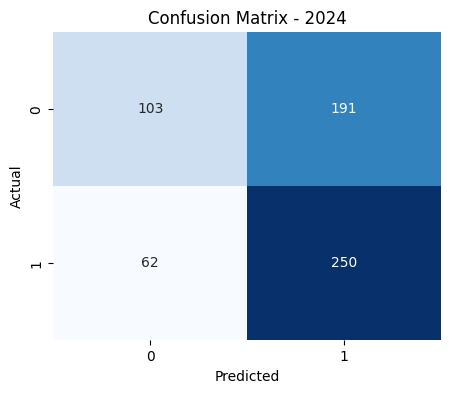


===== Classification Report (2025) =====
              precision    recall  f1-score   support

           0       0.44      0.44      0.44       209
           1       0.61      0.60      0.61       301

    accuracy                           0.54       510
   macro avg       0.52      0.52      0.52       510
weighted avg       0.54      0.54      0.54       510



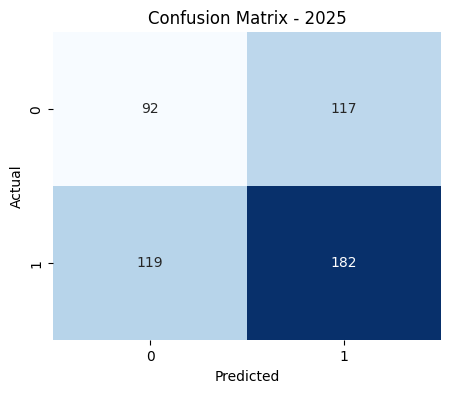

In [2]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# -----------------------------
# Config
# -----------------------------
DATA_PATH = "step5_lagged_data.csv"
MODEL_PATH = "ensemble_model_0p5_0p5.pkl"
TARGET_COL = "direction"
DATE_COL = "month"

# -----------------------------
# Load data and model
# -----------------------------
df = pd.read_csv(DATA_PATH, parse_dates=[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)

with open(MODEL_PATH, "rb") as f:
    model = pickle.load(f)

# -----------------------------
# Feature prep
# -----------------------------
num_cols = df.select_dtypes(include=np.number).columns.tolist()
if TARGET_COL in num_cols:
    num_cols.remove(TARGET_COL)

X = df[num_cols]
y = df[TARGET_COL].astype(int)

# -----------------------------
# Evaluate by year
# -----------------------------
for year in [2024, 2025]:
    df_year = df[df[DATE_COL].dt.year == year]
    if df_year.empty:
        print(f"\nNo data available for {year}.")
        continue

    X_year = df_year[num_cols]
    y_year = df_year[TARGET_COL].astype(int)

    y_pred = model.predict(X_year)
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_year)[:, 1]

    # -----------------------------
    # Classification Report
    # -----------------------------
    print(f"\n===== Classification Report ({year}) =====")
    print(classification_report(y_year, y_pred, zero_division=0))

    # -----------------------------
    # Confusion Matrix
    # -----------------------------
    cm = confusion_matrix(y_year, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {year}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# 3. LSTM RNN Neural Network

## Untuned model

Walk-forward folds:   0%|          | 0/116 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step


Walk-forward folds:   1%|          | 1/116 [00:06<12:34,  6.56s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


Walk-forward folds:   2%|▏         | 2/116 [00:12<11:32,  6.08s/it]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002566D35B100> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


Walk-forward folds:   3%|▎         | 3/116 [00:17<10:38,  5.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step


Walk-forward folds:   3%|▎         | 4/116 [00:22<10:08,  5.43s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step


Walk-forward folds:   4%|▍         | 5/116 [00:27<09:58,  5.39s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


Walk-forward folds:   5%|▌         | 6/116 [00:33<09:47,  5.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step


Walk-forward folds:   6%|▌         | 7/116 [00:38<09:53,  5.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


Walk-forward folds:   7%|▋         | 8/116 [00:45<10:21,  5.76s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step


Walk-forward folds:   8%|▊         | 9/116 [00:50<10:00,  5.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step


Walk-forward folds:   9%|▊         | 10/116 [00:55<09:48,  5.56s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step


Walk-forward folds:   9%|▉         | 11/116 [01:01<09:31,  5.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step


Walk-forward folds:  10%|█         | 12/116 [01:06<09:24,  5.42s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 435ms/step


Walk-forward folds:  11%|█         | 13/116 [01:11<09:11,  5.35s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step


Walk-forward folds:  12%|█▏        | 14/116 [01:16<09:04,  5.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step


Walk-forward folds:  13%|█▎        | 15/116 [01:23<09:24,  5.59s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step


Walk-forward folds:  14%|█▍        | 16/116 [01:28<09:07,  5.48s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step


Walk-forward folds:  15%|█▍        | 17/116 [01:33<08:59,  5.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 431ms/step


Walk-forward folds:  16%|█▌        | 18/116 [01:39<08:55,  5.47s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


Walk-forward folds:  16%|█▋        | 19/116 [01:44<08:41,  5.37s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step


Walk-forward folds:  17%|█▋        | 20/116 [01:49<08:16,  5.17s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step


Walk-forward folds:  18%|█▊        | 21/116 [01:54<08:18,  5.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


Walk-forward folds:  19%|█▉        | 22/116 [01:59<08:10,  5.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step


Walk-forward folds:  20%|█▉        | 23/116 [02:04<08:05,  5.22s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step


Walk-forward folds:  21%|██        | 24/116 [02:11<08:45,  5.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


Walk-forward folds:  22%|██▏       | 25/116 [02:16<08:18,  5.48s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step


Walk-forward folds:  22%|██▏       | 26/116 [02:21<08:07,  5.42s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step


Walk-forward folds:  23%|██▎       | 27/116 [02:27<07:59,  5.39s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step


Walk-forward folds:  24%|██▍       | 28/116 [02:32<07:43,  5.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


Walk-forward folds:  25%|██▌       | 29/116 [02:37<07:32,  5.20s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step


Walk-forward folds:  26%|██▌       | 30/116 [02:42<07:32,  5.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step


Walk-forward folds:  27%|██▋       | 31/116 [02:47<07:26,  5.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


Walk-forward folds:  28%|██▊       | 32/116 [02:53<07:31,  5.37s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step


Walk-forward folds:  28%|██▊       | 33/116 [02:58<07:23,  5.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step


Walk-forward folds:  29%|██▉       | 34/116 [03:06<08:07,  5.95s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 431ms/step


Walk-forward folds:  30%|███       | 35/116 [03:12<08:03,  5.98s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 355ms/step


Walk-forward folds:  31%|███       | 36/116 [03:17<07:41,  5.77s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step


Walk-forward folds:  32%|███▏      | 37/116 [03:23<07:31,  5.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step


Walk-forward folds:  33%|███▎      | 38/116 [03:28<07:20,  5.64s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


Walk-forward folds:  34%|███▎      | 39/116 [03:34<07:11,  5.60s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step


Walk-forward folds:  34%|███▍      | 40/116 [03:39<07:06,  5.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step


Walk-forward folds:  35%|███▌      | 41/116 [03:45<07:07,  5.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step


Walk-forward folds:  36%|███▌      | 42/116 [03:50<06:42,  5.45s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step


Walk-forward folds:  37%|███▋      | 43/116 [03:55<06:38,  5.45s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


Walk-forward folds:  38%|███▊      | 44/116 [04:01<06:39,  5.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


Walk-forward folds:  39%|███▉      | 45/116 [04:07<06:39,  5.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step


Walk-forward folds:  40%|███▉      | 46/116 [04:14<07:07,  6.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step


Walk-forward folds:  41%|████      | 47/116 [04:20<06:47,  5.91s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step


Walk-forward folds:  41%|████▏     | 48/116 [04:25<06:27,  5.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step


Walk-forward folds:  42%|████▏     | 49/116 [04:31<06:19,  5.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step


Walk-forward folds:  43%|████▎     | 50/116 [04:36<06:06,  5.56s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step


Walk-forward folds:  44%|████▍     | 51/116 [04:41<05:59,  5.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


Walk-forward folds:  45%|████▍     | 52/116 [04:47<05:51,  5.50s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step


Walk-forward folds:  46%|████▌     | 53/116 [04:52<05:42,  5.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


Walk-forward folds:  47%|████▋     | 54/116 [04:58<05:40,  5.49s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step


Walk-forward folds:  47%|████▋     | 55/116 [05:03<05:38,  5.55s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


Walk-forward folds:  48%|████▊     | 56/116 [05:09<05:32,  5.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step


Walk-forward folds:  49%|████▉     | 57/116 [05:14<05:26,  5.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step


Walk-forward folds:  50%|█████     | 58/116 [05:20<05:25,  5.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step


Walk-forward folds:  51%|█████     | 59/116 [05:26<05:17,  5.58s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


Walk-forward folds:  52%|█████▏    | 60/116 [05:34<05:57,  6.39s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step


Walk-forward folds:  53%|█████▎    | 61/116 [05:40<05:43,  6.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step


Walk-forward folds:  53%|█████▎    | 62/116 [05:45<05:25,  6.03s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step


Walk-forward folds:  54%|█████▍    | 63/116 [05:51<05:11,  5.88s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


Walk-forward folds:  55%|█████▌    | 64/116 [05:56<04:57,  5.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step


Walk-forward folds:  56%|█████▌    | 65/116 [06:02<04:52,  5.73s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step


Walk-forward folds:  57%|█████▋    | 66/116 [06:08<04:49,  5.80s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step


Walk-forward folds:  58%|█████▊    | 67/116 [06:14<04:40,  5.73s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


Walk-forward folds:  59%|█████▊    | 68/116 [06:19<04:34,  5.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step


Walk-forward folds:  59%|█████▉    | 69/116 [06:25<04:27,  5.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step


Walk-forward folds:  60%|██████    | 70/116 [06:31<04:21,  5.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step


Walk-forward folds:  61%|██████    | 71/116 [06:36<04:17,  5.73s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step


Walk-forward folds:  62%|██████▏   | 72/116 [06:42<04:10,  5.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


Walk-forward folds:  63%|██████▎   | 73/116 [06:48<04:03,  5.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step


Walk-forward folds:  64%|██████▍   | 74/116 [06:53<03:57,  5.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step


Walk-forward folds:  65%|██████▍   | 75/116 [06:59<03:54,  5.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step


Walk-forward folds:  66%|██████▌   | 76/116 [07:05<03:51,  5.78s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step


Walk-forward folds:  66%|██████▋   | 77/116 [07:14<04:23,  6.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step


Walk-forward folds:  67%|██████▋   | 78/116 [07:20<04:07,  6.51s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step


Walk-forward folds:  68%|██████▊   | 79/116 [07:26<03:51,  6.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step


Walk-forward folds:  69%|██████▉   | 80/116 [07:32<03:44,  6.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 431ms/step


Walk-forward folds:  70%|██████▉   | 81/116 [07:37<03:32,  6.07s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step


Walk-forward folds:  71%|███████   | 82/116 [07:43<03:24,  6.00s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step


Walk-forward folds:  72%|███████▏  | 83/116 [07:49<03:14,  5.89s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step


Walk-forward folds:  72%|███████▏  | 84/116 [07:55<03:08,  5.91s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step


Walk-forward folds:  73%|███████▎  | 85/116 [08:01<03:00,  5.83s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


Walk-forward folds:  74%|███████▍  | 86/116 [08:06<02:54,  5.81s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step


Walk-forward folds:  75%|███████▌  | 87/116 [08:12<02:49,  5.85s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step


Walk-forward folds:  76%|███████▌  | 88/116 [08:18<02:44,  5.88s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


Walk-forward folds:  77%|███████▋  | 89/116 [08:24<02:38,  5.88s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step


Walk-forward folds:  78%|███████▊  | 90/116 [08:30<02:32,  5.86s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


Walk-forward folds:  78%|███████▊  | 91/116 [08:36<02:27,  5.88s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


Walk-forward folds:  79%|███████▉  | 92/116 [08:42<02:22,  5.95s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step


Walk-forward folds:  80%|████████  | 93/116 [08:48<02:14,  5.86s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step


Walk-forward folds:  81%|████████  | 94/116 [08:54<02:09,  5.88s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step


Walk-forward folds:  82%|████████▏ | 95/116 [09:00<02:05,  5.96s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


Walk-forward folds:  83%|████████▎ | 96/116 [09:10<02:25,  7.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 441ms/step


Walk-forward folds:  84%|████████▎ | 97/116 [09:16<02:12,  6.98s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step


Walk-forward folds:  84%|████████▍ | 98/116 [09:23<02:02,  6.83s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step


Walk-forward folds:  85%|████████▌ | 99/116 [09:29<01:51,  6.56s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step


Walk-forward folds:  86%|████████▌ | 100/116 [09:35<01:42,  6.40s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step


Walk-forward folds:  87%|████████▋ | 101/116 [09:41<01:33,  6.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step


Walk-forward folds:  88%|████████▊ | 102/116 [09:47<01:27,  6.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step


Walk-forward folds:  89%|████████▉ | 103/116 [09:53<01:20,  6.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step


Walk-forward folds:  90%|████████▉ | 104/116 [09:59<01:14,  6.18s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step


Walk-forward folds:  91%|█████████ | 105/116 [10:06<01:03,  5.77s/it]


----- Walk-forward Backtest Metrics (2015-2023) -----
accuracy: 0.5998
f1: 0.0413
recall: 0.0296
precision: 0.1068
roc_auc: 0.5030


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

----- Blind Test on 2024 -----
accuracy: 0.5057
f1: 0.1761
recall: 0.1073
precision: 0.4912
roc_auc: 0.5433


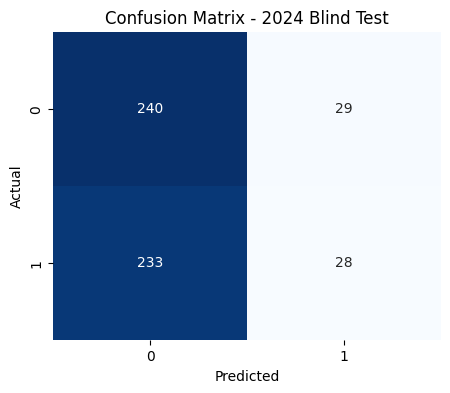


----- Classification Report (2024) -----
              precision    recall  f1-score   support

           0       0.51      0.89      0.65       269
           1       0.49      0.11      0.18       261

    accuracy                           0.51       530
   macro avg       0.50      0.50      0.41       530
weighted avg       0.50      0.51      0.42       530



In [17]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, accuracy_score, recall_score, precision_score,
    roc_auc_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Config
DATA_PATH = "step5_lagged_data.csv"
TARGET_COL = "direction"
DATE_COL = "month"
TICKER_COL = "ticker"
TRAIN_START = "2015-01"
TRAIN_END = "2023-12"
TEST_YEAR = "2024"
TIMESTEPS = 3  # Months of lookback for LSTM input

# Load data
df = pd.read_csv(DATA_PATH, parse_dates=[DATE_COL])
df = df.sort_values([TICKER_COL, DATE_COL]).reset_index(drop=True)

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
if TARGET_COL in numeric_cols:
    numeric_cols.remove(TARGET_COL)

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Create sequences per ticker
def make_sequences(data, labels, timesteps=TIMESTEPS):
    X, y = [], []
    for i in range(timesteps, len(data)):
        X.append(data[i-timesteps:i])
        y.append(labels[i])
    return np.array(X), np.array(y)

# Build baseline LSTM
def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Walk-forward validation
dates = df[DATE_COL].dt.to_period("M")
unique_months = sorted(dates.unique())
preds, metrics_by_fold = [], []

for month_idx in tqdm(range(TIMESTEPS, len(unique_months)), desc="Walk-forward folds"):
    test_month = unique_months[month_idx]
    if str(test_month) > TRAIN_END:
        break
    
    train_months = unique_months[:month_idx]
    test_month = unique_months[month_idx]
    
    train_mask = dates.isin(train_months)
    test_mask = dates == test_month

    X_train_raw = df.loc[train_mask, numeric_cols].values
    y_train = df.loc[train_mask, TARGET_COL].values
    X_test_raw = df.loc[test_mask, numeric_cols].values
    y_test = df.loc[test_mask, TARGET_COL].values

    if len(X_train_raw) < TIMESTEPS or len(X_test_raw) < TIMESTEPS:
        continue

    X_train, y_train = make_sequences(X_train_raw, y_train)
    X_test, y_test = make_sequences(X_test_raw, y_test)

    model = build_lstm((TIMESTEPS, X_train.shape[2]))
    model.fit(X_train, y_train, epochs=5, batch_size=256, verbose=0)

    y_pred_proba = model.predict(X_test).ravel()
    y_pred = (y_pred_proba >= 0.5).astype(int)

    fold_metrics = {
        "month": str(test_month),
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_pred_proba)
    }
    metrics_by_fold.append(fold_metrics)

# Print walk-forward summary
walk_df = pd.DataFrame(metrics_by_fold)
print("\n----- Walk-forward Backtest Metrics (2015-2023) -----")
for metric_name in ["accuracy", "f1", "recall", "precision", "roc_auc"]:
    print(f"{metric_name}: {walk_df[metric_name].mean():.4f}")

# Train final model on all 2015–2023
train_mask = dates.astype(str) <= TRAIN_END
X_train_raw = df.loc[train_mask, numeric_cols].values
y_train = df.loc[train_mask, TARGET_COL].values
X_train, y_train = make_sequences(X_train_raw, y_train)

model_final = build_lstm((TIMESTEPS, X_train.shape[2]))
model_final.fit(X_train, y_train, epochs=5, batch_size=256, verbose=0)

# 2024 blind test
test_mask = dates.astype(str) >= f"{TEST_YEAR}-01"
X_test_raw = df.loc[test_mask, numeric_cols].values
y_test = df.loc[test_mask, TARGET_COL].values
X_test, y_test = make_sequences(X_test_raw, y_test)

y_pred_proba = model_final.predict(X_test).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

print("\n----- Blind Test on 2024 -----")
blind_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred, zero_division=0),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_pred_proba),
}
for k, v in blind_metrics.items():
    print(f"{k}: {v:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - 2024 Blind Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\n----- Classification Report (2024) -----")
print(classification_report(y_test, y_pred, zero_division=0))